# AAA Group project

by Martim Silva 51304 and Alexandre Sobreira 59451

## 0) Imports and Functions

In [2]:
import numpy as np
import pandas as pd 
import os
import cv2
from sklearn.svm import SVC
from skimage.feature import hog
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from skimage.color import rgb2gray
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.applications import VGG16
from skimage.feature import hog
from skimage import data, exposure
import random
from keras import layers, losses
from keras.models import Model
from sklearn.metrics import classification_report, accuracy_score, matthews_corrcoef, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
import math
from keras.utils.np_utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

In [7]:
def display(img):
    plt.imshow(img)
    plt.show()

def prediction_metrics(model, X_test, y_test, classes):
    preds = []
    truth = []
    y_hat = model.predict(X_test)

    for i in range(X_test.shape[0]):
        
        predict_index = np.argmax(y_hat[i])
        preds.append(predict_index) 
        
        true_index = np.argmax(y_test[i])
        truth.append(true_index)
        
    mcc = matthews_corrcoef(truth, preds)
    print("MCC: ", mcc)
    label = list(set(classes))
    cm = confusion_matrix(truth, preds)
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=label, yticklabels=label)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    print(classification_report(truth, preds))

## 1) Data Retrieval

In [9]:
#path martim
#path = "../../../../DadosProj/UTKFace/"
#path alex
path = "../../../data_project/UTKFace/"

files = os.listdir(path)
size = len(files)
print("Total samples:",size)
print(files[0])

Total samples: 23708
100_0_0_20170112213500903.jpg.chip.jpg


## 2) Data Preprocessing

**Changes to images with opencv methods**

- Obtain better contrast for images normalizing the ranges for colors for a pixel between 0 and 255
 - instance = cv2.normalize(instance, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

- Converting to YUV color model, equalizing color histogram to modify 
- distribution of colors taking luminosity into account and
- reconverting to RBG after doing histogram equalization
    - img_yuv = cv2.cvtColor(instance, cv2.COLOR_BGR2YUV)
    - img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    - instance = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

In [10]:
images = []
ages = []
genders = []
ethnicities = []
counter = 0

for file in files:
    if counter == 50:
        break
    
    image = cv2.imread(path+file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, dsize=(200, 200))
    image = image.reshape((image.shape[0], image.shape[1], 3)) ### A ausencia deste ponto  estava a causar o erro no ORB
    #image = image / 255.0 #normalizing values on each point 
    
    images.append(image)
    delimit = file.split('_')
    ages.append(int(delimit[0]))
    # first number is age (0-116 possible values)
    genders.append(int(delimit[1]))
    # second number is gender (0 for male, 1 for female)
    #ethnicities.append(int(delimit[2]))
    # third number is ethnicity (0 for white, 1 for black, 2 for asian, 3 for indian, 4 for any other ethnicity)

    counter += 1

In [11]:
X = np.squeeze(images)

##### Age Classes Separation

Classes choosen based on [US National Institute of Health](https://www.nih.gov/nih-style-guide/age):

- Neonates or newborns (birth to 1 month)
- Infants (1 month to 1 year)
- Children (1 year through 12 years)
- Adolescents (13 years through 17 years. They may also be referred to as teenagers depending on the context.)
- Adults (18 years or older)
- Older adults (65 and older)

In [7]:
print(type(ages))
print(len(ages))
unique_values = list(set(ages))
print(unique_values)

<class 'list'>
1000
[100, 101, 103, 105, 10, 11, 12, 13, 110, 111, 14, 15, 16, 115, 116]


In [12]:
age_classes = []
for i in ages:
    i = int(i)
    if i <= 1:
        age_classes.append(0)
    if (i>1) and (i<=13):
        age_classes.append(1)
    if (i>13) and (i<17):
        age_classes.append(2)
    if (i>=17) and (i<30):
        age_classes.append(3)
    if (i>=30) and (i<60):
        age_classes.append(4)
    if i>=60:
        age_classes.append(5)

In [13]:
age_labels = ["Baby",   # index 0
        "Infant",       # index 1
        "Adolescent",   # index 2 
        "Young Adult",  # index 3 
        "Adult"         # index 4
        "Old Adult",    # index 5
        ]

In [14]:
age_categories = to_categorical(age_classes, num_classes=6)
age_categories[:20]

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

In [11]:
print(len(age_classes))
print(type(age_classes))
unique_values = list(set(age_classes))
print(unique_values)

1000
<class 'list'>
[1, 2, 5]


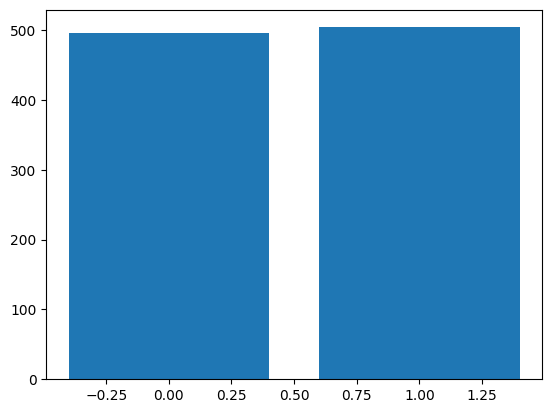

Max value: 1


In [12]:
x_genders = list(set(genders))
y_genders= [genders.count(i) for i in x_genders]
plt.bar(x_genders,y_genders)
plt.show()
print("Max value:",max(genders))

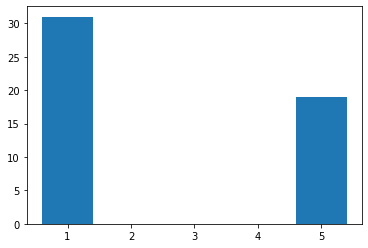

Max value: 5


In [25]:
x_ages = list(set(age_classes))
y_ages = [age_classes.count(i) for i in x_ages]
plt.bar(x_ages,y_ages)
plt.show()
print("Max value:",max(age_classes))

In [14]:
img_all = pd.DataFrame()
img_all["age"] = age_classes
img_all["gender"] = genders

img_gender = pd.DataFrame()
img_gender["gender"] = genders

img_age = pd.DataFrame()
img_age["age"] = age_classes

print("age\n", img_age.age.value_counts())
print("gender\n", img_gender.gender.value_counts())

age
 2    536
1    432
5     32
Name: age, dtype: int64
gender
 1    504
0    496
Name: gender, dtype: int64


Gender Class: 1 Age Class: 5


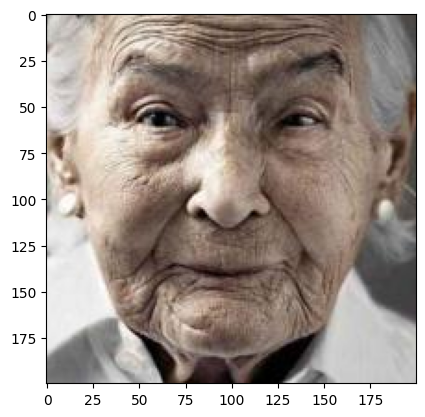

In [15]:
idx = 9
if idx < len(images):
    sample = images[idx]
    print("Gender Class:", genders[idx], "Age Class:", age_classes[idx])
    display(sample)
else:
    print(f"Index {idx} is out of range for the list of {len(images)} images")

## 3) Using preset data

### 3.1) Base SVM with grid search parameter tuning

#### Base SVM image preparation

In [16]:
flattened_images = []

for image in images:
    flattened_image = image.flatten()
    flattened_images.append(flattened_image)

flattened_images_array = np.array(flattened_images)

print(flattened_images_array.shape)

(1000, 120000)


In [17]:
#for i, arr in enumerate(flattened_images_array):
#    print(f"Descriptor array {i} shape: {arr.shape}")

#### Predicting Gender

In [18]:
X_train, X_test, y_train, y_test = train_test_split(flattened_images_array, genders, test_size=0.2, random_state=42)
#print("Samples in Training:",X_train.shape[0])
#print("Samples in Testing:",X_test.shape[0])

MCC:  0.4944074995807303
              precision    recall  f1-score   support

           0       0.78      0.70      0.74       104
           1       0.71      0.79      0.75        96

    accuracy                           0.74       200
   macro avg       0.75      0.75      0.74       200
weighted avg       0.75      0.74      0.74       200



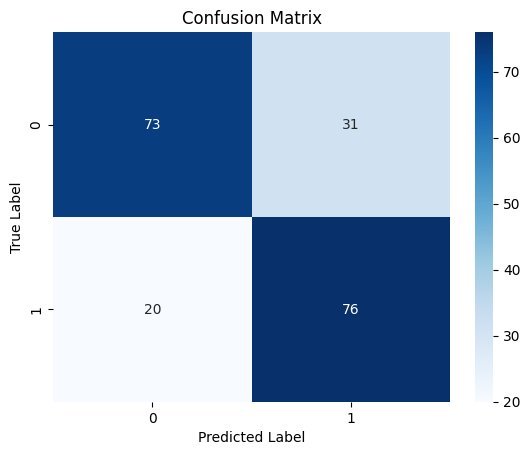

In [19]:
clf = SVC()
clf.fit(X_train, y_train)

# Evaluate the classifier on the testing data
y_pred = clf.predict(X_test)

mcc = matthews_corrcoef(y_test, y_pred)
#accuracy = accuracy_score(y_test, y_pred)
print("MCC: ", mcc)
#print("Accuracy: ", accuracy)
print(classification_report(y_test, y_pred))
#confusion_matrix(y_test, y_pred)

labelGender = list(set(genders))

# assume y_true and y_pred are the true and predicted labels, respectively
cm = confusion_matrix(y_test, y_pred)

# create a heatmap of the confusion matrix using seaborn
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=labelGender, yticklabels=labelGender)

# set plot labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

plt.show()

#### Predicting Age

In [20]:
X_train, X_test, y_train, y_test = train_test_split(flattened_images_array, age_categories, test_size=0.2, random_state=42)
#print("Samples in Training:",X_train.shape[0])
#print("Samples in Testing:",X_test.shape[0])

In [21]:
clf = OneVsRestClassifier(SVC())
clf.fit(X_train, y_train)

# Convert one-hot encoded labels to integer form
y_pred = clf.predict(X_test)

y_test_int = np.argmax(y_test, axis=1)
y_pred_int = np.argmax(y_pred, axis=1)

# Print classification report and confusion matrix

mcc = matthews_corrcoef(y_test_int, y_pred_int)
#accuracy = accuracy_score(y_test, y_pred)
print("MCC: ", mcc)
print(classification_report(y_test_int, y_pred_int))
print(confusion_matrix(y_test_int, y_pred_int))

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\multiclass.py:77: UserWarning: Label not 0 is present in all training examples.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\multiclass.py:77: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\multiclass.py:77: UserWarning: Label not 4 is present in all training examples.
  warnings.warn(


MCC:  0.07137715973384506
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.53      0.10      0.17        89
           2       0.64      0.39      0.48       109
           5       0.00      0.00      0.00         2

    accuracy                           0.26       200
   macro avg       0.29      0.12      0.16       200
weighted avg       0.58      0.26      0.34       200

[[ 0  0  0  0]
 [57  9 23  0]
 [59  8 42  0]
 [ 1  0  1  0]]


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

### 3.2) Base CNN

In [27]:
def CNN (input_shape, output, activation):
    model = tf.keras.Sequential()

    # Must define the input shape in the first layer of the neural network
    
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape = input_shape)) 
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    model.add(tf.keras.layers.Dropout(0.3))

"""    model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    model.add(tf.keras.layers.Dropout(0.3))"""

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(output, activation=activation))
    
    model.summary()
    
    return model

# otimizar 2k
# adicionar mais conv?
# Dropout antes do flaten apenas
# Mexer otimizador (lr)
# implementar early stoping (). Early Stoping tem patience: e.g., 10 epcohs, ele espera 10 epochs antes de parar.
# ir gravando cnn no servidor

#### Predicting Gender

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, genders, test_size=0.2, random_state=42)

In [25]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [26]:
model = CNN((200,200,3), 1, 'sigmoid')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 64)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 100, 100, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 50, 50, 32)        0

In [27]:
#for age use categorical_crossentropy instead
model.compile(optimizer="adam", loss="binary_crossentropy")

history_base_gender = model.fit(X_train, y_train,
                    epochs=3,
                    batch_size=32,
                    validation_data=(X_test, y_test))

Epoch 1/3
25/25 [==============================] - 14s 561ms/step - loss: 564.3523 - val_loss: 2.0551
Epoch 2/3
25/25 [==============================] - 14s 558ms/step - loss: 4.0872 - val_loss: 0.6926
Epoch 3/3
25/25 [==============================] - 14s 549ms/step - loss: 0.7746 - val_loss: 0.6937


7/7 [==============================] - 1s 95ms/step
MCC:  0.0


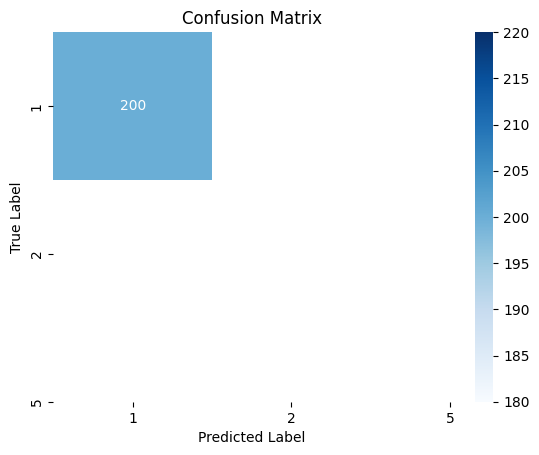

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [28]:
prediction_metrics(model, X_test, y_test, age_classes)

#### Predicting Age

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, age_categories, test_size = 0.2, shuffle = True)

In [30]:
model = CNN((200,200,3), 6, 'softmax')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 200, 200, 64)      832       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 100, 100, 64)     0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 100, 100, 64)      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 32)      8224      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 50, 50, 32)       

In [31]:
model.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

history_base_age = model.fit(X_train, y_train,
        batch_size=8,
        epochs=2,
        validation_data=(X_test, y_test),)

Epoch 1/2
100/100 [==============================] - 30s 300ms/step - loss: 133.3522 - accuracy: 0.4825 - val_loss: 1.6178 - val_accuracy: 0.4300
Epoch 2/2
100/100 [==============================] - 38s 378ms/step - loss: 1.0424 - accuracy: 0.4800 - val_loss: 1.4258 - val_accuracy: 0.4450


7/7 [==============================] - 1s 93ms/step
MCC:  -0.015590180078209056


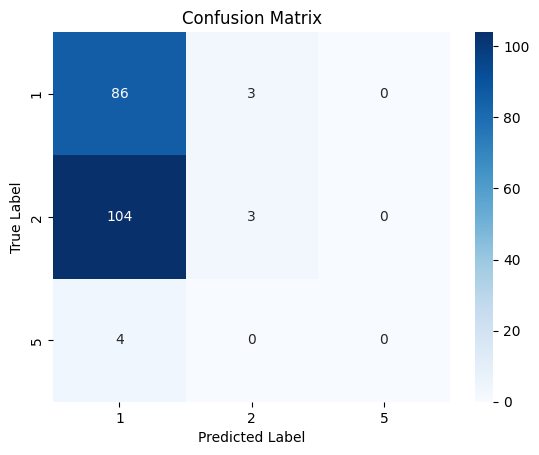

              precision    recall  f1-score   support

           1       0.44      0.97      0.61        89
           2       0.50      0.03      0.05       107
           5       0.00      0.00      0.00         4

    accuracy                           0.45       200
   macro avg       0.31      0.33      0.22       200
weighted avg       0.46      0.45      0.30       200



c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [32]:
prediction_metrics(model, X_test, y_test, age_classes)

## 4) Using Feature extraction methods on data - Histogram of Oriented Gradients (HOG)

### Extraction with HOG

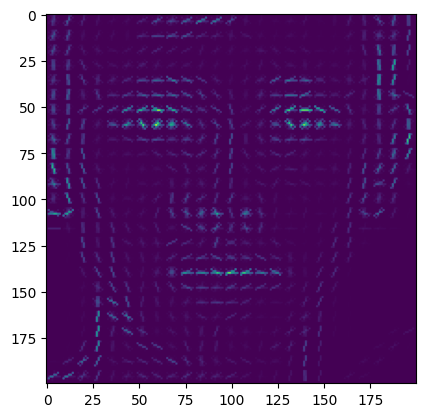

In [33]:
image_check = images[25]

# define HOG parameters
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)

# compute HOG features and visualize them
hog_features, hog_image = hog(image_check, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), transform_sqrt=True, feature_vector=True, visualize=True,channel_axis=2)



# rescale image intensity for better visualization
#hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

# display HOG features
plt.imshow(hog_image)
plt.show()

In [34]:
# Extract HOG features from the images
hog_features = []
for img in images:
    #hog_feature = hog(img, orientations=9, pixels_per_cell=(8, 8),
    #                cells_per_block=(2, 2), transform_sqrt=True, feature_vector=True, multichannel=True, channel_axis=2)
    hog_feature = hog(img, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), transform_sqrt=True, feature_vector=True, channel_axis=2)
    
    hog_features.append(hog_feature)
hog_features = np.array(hog_features)

# Normalize the features to have zero mean and unit variance
mean = np.mean(hog_features, axis=0)
std = np.std(hog_features, axis=0)
hog_features_norm = (hog_features - mean) / std

In [ ]:
#for i, arr in enumerate(hog_features_norm):
#    print(f"Descriptor array {i} shape: {arr.shape}")

### 4.1) SVM with grid search parameter tuning using features extracted from HOG

#### Predicting Gender

In [35]:
X_train, X_test, y_train, y_test = train_test_split(hog_features_norm, genders, test_size=0.2, random_state=42)

In [36]:
clf = SVC()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# Print classification report and confusion matrix

mcc = matthews_corrcoef(y_test, y_pred)
#accuracy = accuracy_score(y_test, y_pred)
print("MCC: ", mcc)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

MCC:  0.6696513629521414
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       104
           1       0.85      0.80      0.82        96

    accuracy                           0.83       200
   macro avg       0.84      0.83      0.83       200
weighted avg       0.84      0.83      0.83       200

[[90 14]
 [19 77]]


#### Predicting Age

In [37]:
X_train, X_test, y_train, y_test = train_test_split(hog_features_norm, age_categories, test_size=0.2, random_state=42)

In [38]:
clf = OneVsRestClassifier(SVC())
clf.fit(X_train, y_train)

# Convert one-hot encoded labels to integer form
y_pred = clf.predict(X_test)

y_test_int = np.argmax(y_test, axis=1)
y_pred_int = np.argmax(y_pred, axis=1)

# Print classification report and confusion matrix

mcc = matthews_corrcoef(y_test_int, y_pred_int)
#accuracy = accuracy_score(y_test, y_pred)
print("MCC: ", mcc)
print(classification_report(y_test_int, y_pred_int))
print(confusion_matrix(y_test_int, y_pred_int))

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\multiclass.py:77: UserWarning: Label not 0 is present in all training examples.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\multiclass.py:77: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\multiclass.py:77: UserWarning: Label not 4 is present in all training examples.
  warnings.warn(


MCC:  0.1417799835047444
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.02      0.04        89
           2       0.88      0.21      0.34       109
           5       0.00      0.00      0.00         2

    accuracy                           0.12       200
   macro avg       0.47      0.06      0.10       200
weighted avg       0.93      0.12      0.21       200

[[ 0  0  0  0]
 [84  2  3  0]
 [86  0 23  0]
 [ 2  0  0  0]]


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

### 4.2) CNN using features extracted from HOG

#### Predicting Gender

In [39]:
cnn = Sequential()

#tratado
cnn.add(layers.Reshape((144, 144, 1), input_shape=(20736,)))
#cnn.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=X_train[1].shape))

cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D(2,2))
cnn.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D(2,2))
cnn.add(Flatten())
cnn.add(Dense(64, activation='relu'))
cnn.add(layers.Dropout(0.2))

#output layer with 2 filters for number of classes the model will choose to do predictions
#and since gender is just binary classification sigmoid is appropriate
#when doing classification for age (wont be binary classification) then softmax is good choice
cnn.add(Dense(1, activation='sigmoid'))

#cnn.summary()

In [40]:
X_train, X_test, y_train, y_test = train_test_split(hog_features_norm, genders, test_size=0.2, random_state=42)

In [41]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [42]:
cnn.compile(optimizer="adam", loss="binary_crossentropy")

history_hog_gender = cnn.fit(X_train, y_train,
                    epochs=2,
                    batch_size=32,
                    validation_data=(X_test, y_test))

Epoch 1/2
25/25 [==============================] - 2s 52ms/step - loss: 1.0056 - val_loss: 0.6914
Epoch 2/2
25/25 [==============================] - 1s 49ms/step - loss: 0.6882 - val_loss: 0.6820


7/7 [==============================] - 0s 11ms/step
MCC:  0.0


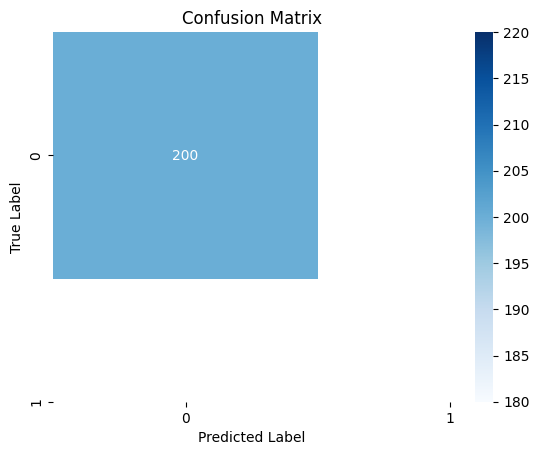

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [43]:
prediction_metrics(cnn, X_test, y_test, genders)

#### Predicting Age

In [44]:
cnn = Sequential()

cnn.add(layers.Reshape((144, 144, 1), input_shape=(20736,)))
#cnn.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=X_train[1].shape))

cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D(2,2))
cnn.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D(2,2))
cnn.add(Flatten())
cnn.add(Dense(64, activation='relu'))
cnn.add(layers.Dropout(0.2))

#output layer with 2 filters for number of classes the model will choose to do predictions
#and since gender is just binary classification sigmoid is appropriate
#when doing classification for age (wont be binary classification) then softmax is good choice
cnn.add(Dense(6, activation='softmax'))

#cnn.summary()

In [45]:
X_train, X_test, y_train, y_test = train_test_split(hog_features_norm, age_categories, test_size = 0.2,shuffle = True)

In [46]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [47]:
cnn.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

history_hog_age = cnn.fit(X_train, y_train,
        batch_size=8,
        epochs=2,
        validation_data=(X_test, y_test),)

Epoch 1/2
100/100 [==============================] - 2s 21ms/step - loss: 1.0141 - accuracy: 0.5300 - val_loss: 0.8934 - val_accuracy: 0.4400
Epoch 2/2
100/100 [==============================] - 2s 20ms/step - loss: 0.8223 - accuracy: 0.5200 - val_loss: 0.8657 - val_accuracy: 0.5100


7/7 [==============================] - 0s 11ms/step
MCC:  0.0


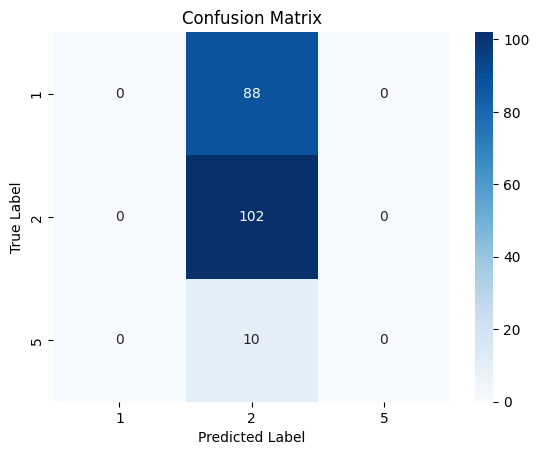

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        88
           2       0.51      1.00      0.68       102
           5       0.00      0.00      0.00        10

    accuracy                           0.51       200
   macro avg       0.17      0.33      0.23       200
weighted avg       0.26      0.51      0.34       200



c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [48]:
prediction_metrics(cnn, X_test, y_test, age_classes)

## 5) Using Feature extraction methods on data - Oriented FAST and Rotated BRIEF (ORB)

### Extraction with ORB

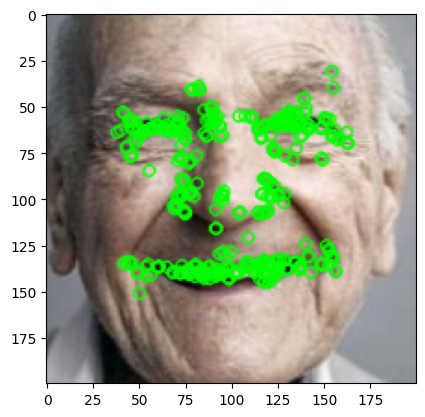

In [49]:
image_check = images[1]

orb = cv2.ORB_create()

kp = orb.detect(image_check, None)

kp, des = orb.compute(image_check, kp)

img2 = cv2.drawKeypoints(image_check, kp, None, color=(0,255,0), flags=0)
plt.imshow(img2)
plt.show()

In [ ]:
#image[0].shape

In [54]:
orb = cv2.ORB_create()
# define minimum and maximum keypoints
MIN_KEYPOINTS = 100
orb_features = []
orb_genders = []
orb_ages = []

# loop over images and keypoints
for i, img in enumerate(images):
    keypoints, descriptors = orb.detectAndCompute(img, None)
    keypoints, descriptors = orb.compute(image_check, keypoints)
    keypoints = list(keypoints)    
    # check if number of keypoints is between min and max
    if len(keypoints) < MIN_KEYPOINTS:
        continue
        
    # remove extra keypoints randomly
    while len(keypoints) > MIN_KEYPOINTS:
        idx = random.randint(0, len(keypoints)-1)
        keypoints.pop(idx)
        descriptors = np.delete(descriptors, idx, axis=0)
        
    # add descriptors to feature list
    orb_features.append(np.ndarray.flatten(descriptors))
    orb_genders.append(genders[i])
    orb_ages.append(age_categories[i])

In [ ]:
#print(len(Genders))
#print(len(Age))
#print(len(orb_features))

In [ ]:
#for i, arr in enumerate(orb_features):
#    print(f"Descriptor array {i} shape: {arr.shape}")

In [51]:
mean = np.mean(orb_features, axis=0)
std = np.std(orb_features, axis=0)
orb_features_norm = (orb_features - mean) / std

### 5.1) SVM with grid search parameter tuning using features extracted from ORB

#### Predicting Gender

In [55]:
X_train, X_test, y_train, y_test = train_test_split(orb_features_norm, orb_genders, test_size=0.2, random_state=42)

MCC:  0.011176994794839842
              precision    recall  f1-score   support

           0       0.44      0.81      0.57        62
           1       0.57      0.20      0.30        79

    accuracy                           0.47       141
   macro avg       0.51      0.50      0.44       141
weighted avg       0.51      0.47      0.42       141



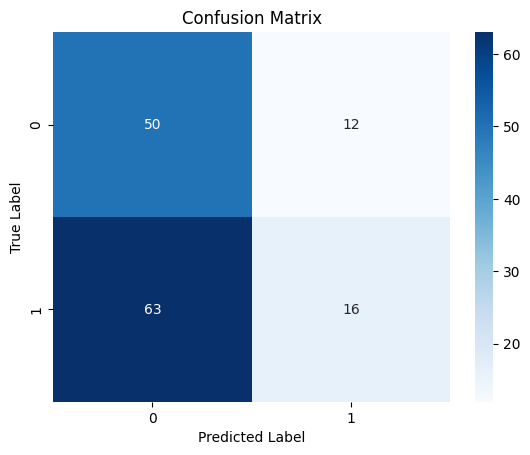

In [57]:
clf = SVC()
clf.fit(X_train, y_train)

# Evaluate the classifier on the testing data
y_pred = clf.predict(X_test)

mcc = matthews_corrcoef(y_test, y_pred)
#accuracy = accuracy_score(y_test, y_pred)
print("MCC: ", mcc)
#print("Accuracy: ", accuracy)
print(classification_report(y_test, y_pred))
#confusion_matrix(y_test, y_pred)

labelGender = list(set(genders))

# assume y_true and y_pred are the true and predicted labels, respectively
cm = confusion_matrix(y_test, y_pred)

# create a heatmap of the confusion matrix using seaborn
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=labelGender, yticklabels=labelGender)

# set plot labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

plt.show()

#### Predicting Age

In [58]:
X_train, X_test, y_train, y_test = train_test_split(orb_features_norm, orb_ages, test_size=0.2, random_state=42)

In [59]:
clf = OneVsRestClassifier(SVC())
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

y_test_int = np.argmax(y_test, axis=1)
y_pred_int = np.argmax(y_pred, axis=1)

# Print classification report and confusion matrix

mcc = matthews_corrcoef(y_test_int, y_pred_int)
#accuracy = accuracy_score(y_test, y_pred)
print("MCC: ", mcc)
print(classification_report(y_test_int, y_pred_int))
print(confusion_matrix(y_test_int, y_pred_int))

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\multiclass.py:77: UserWarning: Label not 0 is present in all training examples.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\multiclass.py:77: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\multiclass.py:77: UserWarning: Label not 4 is present in all training examples.
  warnings.warn(


MCC:  -0.028076522596434002
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00        77
           2       0.25      0.02      0.03        59
           5       0.00      0.00      0.00         5

    accuracy                           0.01       141
   macro avg       0.06      0.00      0.01       141
weighted avg       0.10      0.01      0.01       141

[[ 0  0  0  0]
 [74  0  3  0]
 [58  0  1  0]
 [ 5  0  0  0]]


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

### 5.2) CNN using features extracted from ORB

#### Predicting Gender

In [60]:
X_train, X_test, y_train, y_test = train_test_split(orb_features_norm, orb_genders, test_size=0.20, random_state=42)

In [61]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [62]:
cnn = Sequential()

# Input shape is (3200,)
cnn.add(layers.Reshape((50, 64, 1), input_shape=X_train[0].shape))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
##cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn.add(Flatten())
cnn.add(layers.Dense(64, activation='relu'))
cnn.add(layers.Dropout(0.2))
cnn.add(layers.Dense(1, activation='sigmoid'))

#cnn.summary()

In [63]:
cnn.compile(optimizer="adam", loss="binary_crossentropy")

history_orb_gender = cnn.fit(X_train, y_train,
                        epochs=2,
                        batch_size=32,
                        validation_data=(X_test, y_test))

Epoch 1/2
18/18 [==============================] - 1s 39ms/step - loss: 1.0740 - val_loss: 0.6925
Epoch 2/2
18/18 [==============================] - 1s 36ms/step - loss: 0.6922 - val_loss: 0.6942


5/5 [==============================] - 0s 5ms/step
MCC:  0.0


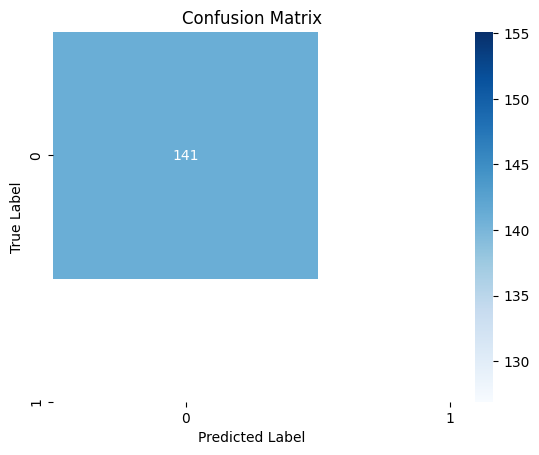

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       141

    accuracy                           1.00       141
   macro avg       1.00      1.00      1.00       141
weighted avg       1.00      1.00      1.00       141



In [64]:
prediction_metrics(cnn, X_test, y_test, orb_genders)

#### Predicting Age

In [65]:
X_train, X_test, y_train, y_test = train_test_split(orb_features_norm, orb_ages, test_size=0.20, random_state=42)

In [66]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [67]:
cnn = Sequential()

# Input shape is (3200,)
cnn.add(layers.Reshape((50, 64, 1), input_shape=X_train[0].shape))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
##cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn.add(Flatten())
cnn.add(layers.Dense(64, activation='relu'))
cnn.add(layers.Dropout(0.2))
cnn.add(layers.Dense(6, activation='softmax'))

#cnn.summary()

In [68]:
cnn.compile(optimizer="adam", loss="binary_crossentropy")

history_orb_gender = cnn.fit(X_train, y_train,
                        epochs=2,
                        batch_size=32,
                        validation_data=(X_test, y_test))

Epoch 1/2
18/18 [==============================] - 1s 39ms/step - loss: 0.4067 - val_loss: 0.3100
Epoch 2/2
18/18 [==============================] - 1s 35ms/step - loss: 0.2848 - val_loss: 0.2887


5/5 [==============================] - 0s 5ms/step
MCC:  0.0


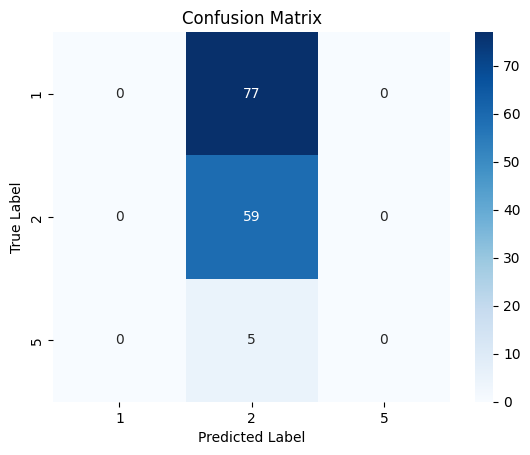

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        77
           2       0.42      1.00      0.59        59
           5       0.00      0.00      0.00         5

    accuracy                           0.42       141
   macro avg       0.14      0.33      0.20       141
weighted avg       0.18      0.42      0.25       141



c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [69]:
prediction_metrics(cnn, X_test, y_test, age_classes)

## 6) Using Feature extraction methods on data - "Very Deep Convolutional Networks for Large-Scale Image Recognition" (VGG-16)

### Extraction with VGG-16

In [70]:
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

for layer in VGG_model.layers:
	layer.trainable = False
	
VGG_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [71]:
X = np.stack(images)
X = VGG_model.predict(X)

32/32 [==============================] - 32s 994ms/step


### 6.1) SVM with grid search parameter tuning using features extracted from VGG-16

#### Predicting Gender

In [72]:
X_svm = X.reshape(X.shape[0], -1)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X_svm, genders, test_size=0.2, random_state=42)

MCC:  0.7321151888842847
              precision    recall  f1-score   support

           0       0.90      0.84      0.87       104
           1       0.83      0.90      0.86        96

    accuracy                           0.86       200
   macro avg       0.87      0.87      0.86       200
weighted avg       0.87      0.86      0.87       200



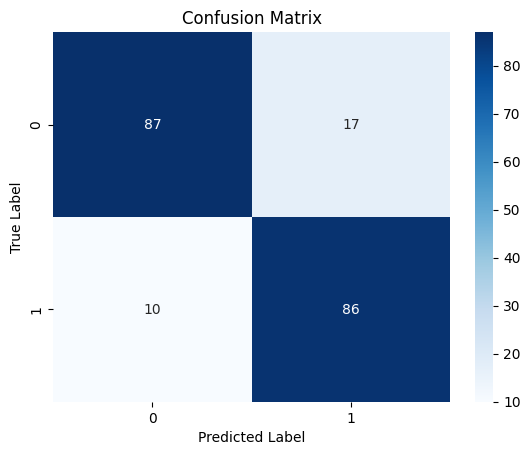

In [74]:
clf = SVC()
clf.fit(X_train, y_train)

# Evaluate the classifier on the testing data
y_pred = clf.predict(X_test)

mcc = matthews_corrcoef(y_test, y_pred)
#accuracy = accuracy_score(y_test, y_pred)
print("MCC: ", mcc)
#print("Accuracy: ", accuracy)
print(classification_report(y_test, y_pred))
#confusion_matrix(y_test, y_pred)

labelGender = list(set(genders))

# assume y_true and y_pred are the true and predicted labels, respectively
cm = confusion_matrix(y_test, y_pred)

# create a heatmap of the confusion matrix using seaborn
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=labelGender, yticklabels=labelGender)

# set plot labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

plt.show()

#### Predicting Age

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X_svm, age_categories, test_size=0.2, random_state=42)#variar a percentagem split

In [76]:
clf = OneVsRestClassifier(SVC())
clf.fit(X_train, y_train)

# Convert one-hot encoded labels to integer form
y_pred = clf.predict(X_test)

y_test_int = np.argmax(y_test, axis=1)
y_pred_int = np.argmax(y_pred, axis=1)

# Print classification report and confusion matrix

mcc = matthews_corrcoef(y_test_int, y_pred_int)
#accuracy = accuracy_score(y_test, y_pred)
print("MCC: ", mcc)
print(classification_report(y_test_int, y_pred_int))
print(confusion_matrix(y_test_int, y_pred_int))

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\multiclass.py:77: UserWarning: Label not 0 is present in all training examples.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\multiclass.py:77: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\multiclass.py:77: UserWarning: Label not 4 is present in all training examples.
  warnings.warn(


MCC:  0.16476124679306928
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.08      0.15        89
           2       0.78      0.35      0.48       109
           5       0.00      0.00      0.00         2

    accuracy                           0.23       200
   macro avg       0.44      0.11      0.16       200
weighted avg       0.87      0.23      0.33       200

[[ 0  0  0  0]
 [71  7 11  0]
 [71  0 38  0]
 [ 2  0  0  0]]


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

### 6.2) CNN using features extracted from VGG-16

#### Predicting Gender

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, genders, test_size=0.2, random_state=42)

In [78]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [79]:
model = CNN((6, 6, 512), 1, 'sigmoid')

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 6, 6, 64)          131136    
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 3, 3, 64)         0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 3, 3, 64)          0         
                                                                 
 conv2d_13 (Conv2D)          (None, 3, 3, 32)          8224      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 1, 1, 32)         0         
 g2D)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 1, 1, 32)         

In [80]:
#for age use categorical_crossentropy instead
model.compile(optimizer="adam", loss="binary_crossentropy")

history_VGG16_gender = model.fit(X_train, y_train,
                    epochs=3,
                    batch_size=32,
                    validation_data=(X_test, y_test))

Epoch 1/3
25/25 [==============================] - 1s 9ms/step - loss: 2.1969 - val_loss: 0.6458
Epoch 2/3
25/25 [==============================] - 0s 7ms/step - loss: 0.8820 - val_loss: 0.6681
Epoch 3/3
25/25 [==============================] - 0s 7ms/step - loss: 0.6955 - val_loss: 0.6419


7/7 [==============================] - 0s 2ms/step
MCC:  0.0


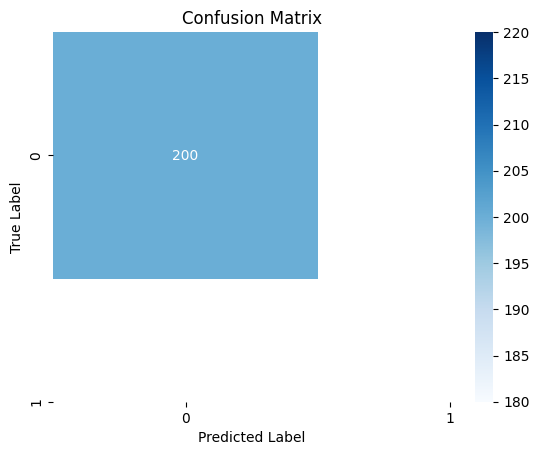

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [81]:
prediction_metrics(model, X_test, y_test, genders)

#### Predicting Age

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, age_categories, test_size=0.2, random_state=42)

In [83]:
model = CNN((6,6,512), 6, 'softmax')

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 6, 6, 64)          131136    
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 3, 3, 64)         0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 3, 3, 64)          0         
                                                                 
 conv2d_15 (Conv2D)          (None, 3, 3, 32)          8224      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 1, 1, 32)         0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 1, 1, 32)         

In [84]:
model.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

history_VGG16_age = model.fit(X_train, y_train,
        batch_size=8,
        epochs=2,
        validation_data=(X_test, y_test),)

Epoch 1/2
100/100 [==============================] - 1s 4ms/step - loss: 2.7684 - accuracy: 0.4500 - val_loss: 1.0394 - val_accuracy: 0.5600
Epoch 2/2
100/100 [==============================] - 0s 3ms/step - loss: 1.1360 - accuracy: 0.4737 - val_loss: 1.1896 - val_accuracy: 0.5500


7/7 [==============================] - 0s 2ms/step
MCC:  0.009757639969351452


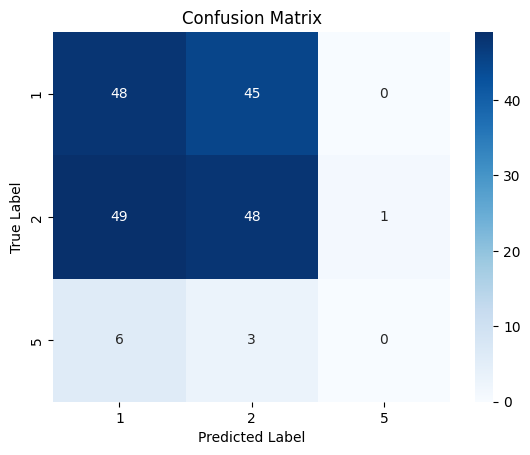

              precision    recall  f1-score   support

           1       0.47      0.52      0.49        93
           2       0.50      0.49      0.49        98
           5       0.00      0.00      0.00         9

    accuracy                           0.48       200
   macro avg       0.32      0.34      0.33       200
weighted avg       0.46      0.48      0.47       200



In [85]:
prediction_metrics(model, X_test, y_train, age_classes)

## 7) Using Feature extraction methods on data - Autoencoder

### Extraction with Autoencoder

In [15]:
input = layers.Input(shape=(200, 200, 3))

#valor alto apanha artefactos, e valor baixo nao captura bem as features da imagem
latent_dim = 2000


## Classe 

# Encoder

#didnt increase filter count in encoder and decrease equally in decoder because
#it can lead to overfitting



x = layers.Conv2D(64, (3,3), activation='relu', padding='same', strides = 2)(input)
#x = layers.MaxPooling2D((2,2), padding='same')(x)#dividir imagem por factor de 2
x = layers.Conv2D(32, (3,3), activation='relu', padding='same', strides = 2)(x)#reduziu se nr de filtros para 32 porque foi decidido factor de 32 filtros
#x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Conv2D(16, (3,3), activation='relu', padding='same', strides = 2)(x)
#x = layers.MaxPooling2D((2,2), padding='same')(x)#25*25*16=10000
x = layers.Flatten()(x)
enc = layers.Dense(latent_dim, activation='relu')(x)

# Decoder

#having conv2D here helps to avoid checkerboard artifacts
#which are alternating points of colors (like checkerboard)
#that are consequence of deconvolutioning an image and cause 
#loss of quality in final reconstruction
#x = layers.Conv2D(16, (3,3), activation='relu', padding='same')(x)

#equivalente a fazer dense layer no fim do encoder e no inicio do decoder
#fazer a layer dense fica um vector
#fazer reshape depois do 2 dense para voltar a ter imagem do vetor criado

x = layers.Dense(25*25*16, activation='relu')(enc)
x = layers.Reshape((25,25,16))(x)
#x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2DTranspose(32, (3, 3), activation="relu", padding="same", strides = 2)(x)
#x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2DTranspose(64, (3,3), activation='relu', padding='same', strides = 2)(x)
#x = layers.UpSampling2D((2,2))(x)
output = layers.Conv2DTranspose(3, (3,3), activation='sigmoid', padding='same', strides = 2)(x)


#maybe use strides in the layers too
#example:
#x = layers.Conv2D(16, (3,3), activation='relu', padding='same', strides = 2)(x)

# Autoencoder
autoencoder = Model(input, output)

# binary cross entropy is good for image feature extraction especially when images are normalized
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
#autoencoder.summary()

### 7.1) SVM with grid search parameter tuning using features extracted from the Autoencoder

#### Predicting Gender

In [16]:
# for this the order is first the split of the data then using autoencoder on train_x
X_train, X_test, y_train, y_test = train_test_split(images, genders, test_size=0.2, random_state=42)

In [17]:
X_train = np.array(X_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 3))

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 3))

In [18]:
# binary cross entropy is good for image feature extraction especially when images are normalized
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 64)      1792      
                                                                 
 conv2d_4 (Conv2D)           (None, 50, 50, 32)        18464     
                                                                 
 conv2d_5 (Conv2D)           (None, 25, 25, 16)        4624      
                                                                 
 flatten_1 (Flatten)         (None, 10000)             0         
                                                                 
 dense_2 (Dense)             (None, 2000)              20002000  
                                                                 
 dense_3 (Dense)             (None, 10000)             2001

In [92]:
#using validation_data is good for detecting overfitting as 
#it does early stopping when the performance is no longer improving

autoencoder.fit(x = X_train, 
                y = X_train,
                epochs = 2,
                shuffle = True,
                batch_size = 32,
                validation_data = (X_test, X_test),)

Epoch 1/2
25/25 [==============================] - 13s 490ms/step - loss: -143523072.0000 - val_loss: -1708158976.0000
Epoch 2/2
25/25 [==============================] - 12s 478ms/step - loss: -477887954944.0000 - val_loss: -3484980346880.0000


In [19]:
new_model = Model(input, enc)

In [23]:
pred_train = new_model.predict(X_train)
pred_test = new_model.predict(X_test)

1/1 [==============================] - 0s 93ms/step


In [93]:
encoded_X_train = autoencoder.predict(X_train)
encoded_X_test = autoencoder.predict(X_test)

encoded_X_train = encoded_X_train.reshape((encoded_X_train.shape[0], -1))
encoded_X_test = encoded_X_test.reshape((encoded_X_test.shape[0], -1))

7/7 [==============================] - 1s 85ms/step


In [ ]:
#pode ser que fazer flatten nas imagens seja a solucao
#outra opcao ser nao ter validation_data campo no fit do autoencoder
#porque esta a testar imagens de train contra de teste quando nao 
#faz sentido fazer isso num autoencoder

#verificar com stora na quinta feira..

"""
flattened_images = []

for image in images:
    flattened_image = image.flatten()
    flattened_images.append(flattened_image)

flattened_images_array = np.array(flattened_images)

print(flattened_images_array.shape)
"""

MCC:  0.0
              precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       0.00      0.00      0.00         1

    accuracy                           0.90        10
   macro avg       0.45      0.50      0.47        10
weighted avg       0.81      0.90      0.85        10



c:\Users\afbso\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\afbso\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\afbso\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


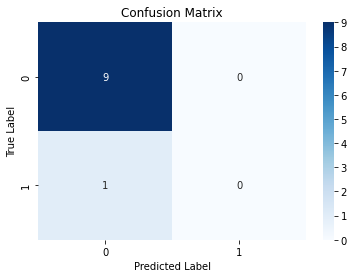

In [24]:
clf = SVC()
clf.fit(pred_train, y_train)

# Evaluate the classifier on the testing data
y_pred = clf.predict(pred_test)

mcc = matthews_corrcoef(y_test, y_pred)
#accuracy = accuracy_score(y_test, y_pred)
print("MCC: ", mcc)
#print("Accuracy: ", accuracy)
print(classification_report(y_test, y_pred))
#confusion_matrix(y_test, y_pred)

labelGender = list(set(genders))

# assume y_true and y_pred are the true and predicted labels, respectively
cm = confusion_matrix(y_test, y_pred)

# create a heatmap of the confusion matrix using seaborn
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=labelGender, yticklabels=labelGender)

# set plot labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

plt.show()

In [26]:
np.unique(y_test)

array([0, 1])

#### Predicting Age

In [95]:
# for this the order is first the split of the data then using autoencoder on train_x
X_train, X_test, y_train, y_test = train_test_split(images, age_categories, test_size=0.2, random_state=42)

In [96]:
X_train = np.array(X_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 3))

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 3))

In [97]:
input = layers.Input(shape=(200, 200, 3))

In [98]:
# binary cross entropy is good for image feature extraction especially when images are normalized
autoencoder.compile(optimizer="adam", loss='categorical_crossentropy')
autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 conv2d_16 (Conv2D)          (None, 100, 100, 64)      1792      
                                                                 
 conv2d_17 (Conv2D)          (None, 50, 50, 32)        18464     
                                                                 
 conv2d_18 (Conv2D)          (None, 25, 25, 16)        4624      
                                                                 
 flatten_8 (Flatten)         (None, 10000)             0         
                                                                 
 dense_16 (Dense)            (None, 2000)              20002000  
                                                                 
 dense_17 (Dense)            (None, 10000)             200100

In [99]:
autoencoder.fit(x = X_train, 
                y = X_train,
                epochs = 2,
                shuffle = True,
                batch_size = 32,
                validation_data = (X_test, X_test),
)

Epoch 1/2
25/25 [==============================] - 12s 473ms/step - loss: 6061243760640.0000 - val_loss: 19546404552704.0000
Epoch 2/2
25/25 [==============================] - 12s 470ms/step - loss: 100172545654784.0000 - val_loss: 290537357705216.0000


In [100]:
encoded_X_train = autoencoder.predict(X_train)
encoded_X_test = autoencoder.predict(X_test)

encoded_X_train = encoded_X_train.reshape((encoded_X_train.shape[0], -1))
encoded_X_test = encoded_X_test.reshape((encoded_X_test.shape[0], -1))

7/7 [==============================] - 1s 89ms/step


In [101]:
clf = OneVsRestClassifier(SVC())
clf.fit(encoded_X_train, y_train)

# Convert one-hot encoded labels to integer form
y_pred = clf.predict(encoded_X_test)

y_test_int = np.argmax(y_test, axis=1)
y_pred_int = np.argmax(y_pred, axis=1)

# Print classification report and confusion matrix

mcc = matthews_corrcoef(y_test_int, y_pred_int)
#accuracy = accuracy_score(y_test, y_pred)
print("MCC: ", mcc)
print(classification_report(y_test_int, y_pred_int))
print(confusion_matrix(y_test_int, y_pred_int))

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\multiclass.py:77: UserWarning: Label not 0 is present in all training examples.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\multiclass.py:77: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\multiclass.py:77: UserWarning: Label not 4 is present in all training examples.
  warnings.warn(


MCC:  0.0
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        89
           2       0.55      1.00      0.71       109
           5       0.00      0.00      0.00         2

    accuracy                           0.55       200
   macro avg       0.18      0.33      0.24       200
weighted avg       0.30      0.55      0.38       200

[[  0  89   0]
 [  0 109   0]
 [  0   2   0]]


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

### 7.2) CNN using features extracted from the Autoencoder

#### Predicting Gender

In [102]:
X_train, X_test, y_train, y_test = train_test_split(images, genders, test_size=0.2, random_state=42)

In [103]:
X_train = np.array(X_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 3))

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 3))

In [104]:
input = layers.Input(shape=(200, 200, 3))

In [105]:
# binary cross entropy is good for image feature extraction especially when images are normalized
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 conv2d_16 (Conv2D)          (None, 100, 100, 64)      1792      
                                                                 
 conv2d_17 (Conv2D)          (None, 50, 50, 32)        18464     
                                                                 
 conv2d_18 (Conv2D)          (None, 25, 25, 16)        4624      
                                                                 
 flatten_8 (Flatten)         (None, 10000)             0         
                                                                 
 dense_16 (Dense)            (None, 2000)              20002000  
                                                                 
 dense_17 (Dense)            (None, 10000)             200100

In [106]:
#using validation_data is good for detecting overfitting as 
#it does early stopping when the performance is no longer improving

autoencoder.fit(x = X_train, 
                y = X_train,
                epochs = 2,
                shuffle = True,
                batch_size = 32,
                validation_data = (X_test, X_test),)

Epoch 1/2
25/25 [==============================] - 13s 497ms/step - loss: -6404389480693760.0000 - val_loss: -13470751533301760.0000
Epoch 2/2
25/25 [==============================] - 12s 497ms/step - loss: -36696475454930944.0000 - val_loss: -80392321673199616.0000


In [107]:
#encoder = Model(inputs=input, outputs=autoencoder.get_layer("conv2d_transpose_55").output)
encoded_train = autoencoder.predict(X_train)
encoded_test = autoencoder.predict(X_test)

7/7 [==============================] - 1s 90ms/step


In [108]:
encoded_train = np.asarray(encoded_train)
y_train = np.asarray(y_train)

encoded_test = np.asarray(encoded_test)
y_test = np.asarray(y_test)

In [109]:
model = CNN((200, 200, 3), 1, 'sigmoid')

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 200, 200, 64)      832       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 100, 100, 64)     0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 100, 100, 64)      0         
                                                                 
 conv2d_20 (Conv2D)          (None, 100, 100, 32)      8224      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 50, 50, 32)       

In [110]:
#for age use categorical_crossentropy instead
model.compile(optimizer="adam", loss="binary_crossentropy")

history_autoencoder_gender = model.fit(encoded_train, y_train,
                    epochs=3,
                    batch_size=32,
                    validation_data=(encoded_test, y_test))

Epoch 1/3
25/25 [==============================] - 14s 533ms/step - loss: 3.4117 - val_loss: 0.6933
Epoch 2/3
25/25 [==============================] - 13s 531ms/step - loss: 0.6930 - val_loss: 0.6933
Epoch 3/3
25/25 [==============================] - 14s 552ms/step - loss: 0.6932 - val_loss: 0.6934


7/7 [==============================] - 1s 93ms/step
MCC:  0.0


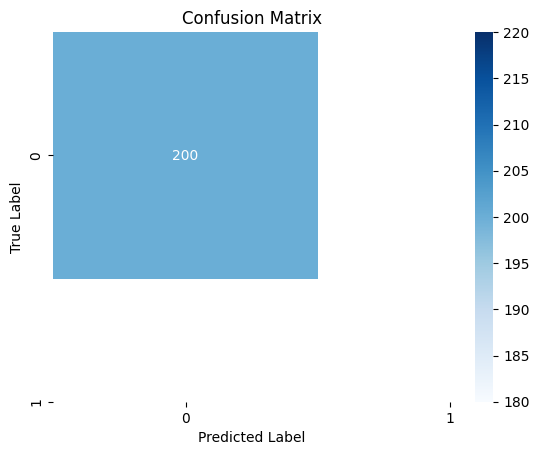

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [112]:
prediction_metrics(model, encoded_test, y_test, genders)

#### Predicting Age

In [113]:
X_train, X_test, y_train, y_test = train_test_split(images, age_categories, test_size=0.2, random_state=42)

In [114]:
X_train = np.array(X_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 3))

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 3))

In [115]:
input = layers.Input(shape=(200, 200, 3))

In [116]:
autoencoder.fit(x = X_train, 
                y = X_train,
                epochs = 2,
                shuffle = True,
                batch_size = 32,
                validation_data = (X_test, X_test),
)

Epoch 1/2
25/25 [==============================] - 12s 499ms/step - loss: -219925002982522880.0000 - val_loss: -482785247834931200.0000
Epoch 2/2
25/25 [==============================] - 18s 695ms/step - loss: -1268232511691948032.0000 - val_loss: -2613071571903840256.0000


In [117]:
encoded_train = autoencoder.predict(X_train)
encoded_test = autoencoder.predict(X_test)

7/7 [==============================] - 1s 86ms/step


In [118]:
encoded_train = np.asarray(encoded_train)
y_train = np.asarray(y_train)

encoded_test = np.asarray(encoded_test)
y_test = np.asarray(y_test)

In [119]:
model = CNN((200,200,3), 6, 'softmax')

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 200, 200, 64)      832       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 100, 100, 64)     0         
 g2D)                                                            
                                                                 
 dropout_19 (Dropout)        (None, 100, 100, 64)      0         
                                                                 
 conv2d_22 (Conv2D)          (None, 100, 100, 32)      8224      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 50, 50, 32)       

In [120]:
model.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

history_base_age = model.fit(encoded_train, y_train,
        batch_size=8,
        epochs=2,
        validation_data=(encoded_test, y_test),)

Epoch 1/2
100/100 [==============================] - 22s 216ms/step - loss: 1.7523 - accuracy: 0.4900 - val_loss: 1.1281 - val_accuracy: 0.5450
Epoch 2/2
100/100 [==============================] - 21s 212ms/step - loss: 0.8858 - accuracy: 0.5000 - val_loss: 0.8961 - val_accuracy: 0.5450


7/7 [==============================] - 1s 91ms/step
MCC:  0.0


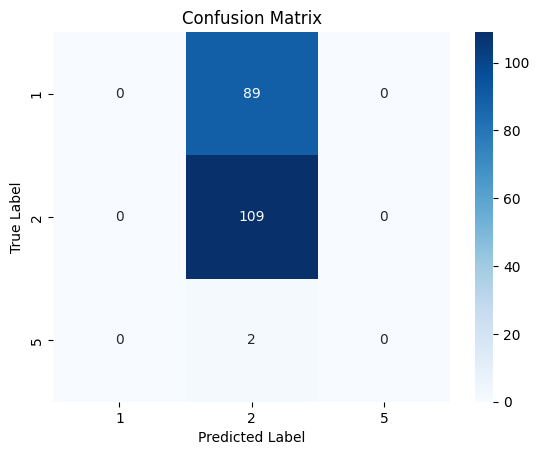

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        89
           2       0.55      1.00      0.71       109
           5       0.00      0.00      0.00         2

    accuracy                           0.55       200
   macro avg       0.18      0.33      0.24       200
weighted avg       0.30      0.55      0.38       200



c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [121]:
prediction_metrics(model, X_test, y_test, age_classes)

### Dataframe of Accuracies for each version used of the data (SVM)

In [122]:
data_gender = {'Models': ['Base', 'Hog', 'Orb', 'VGG 16', 'Autoencoder'],
        'Accuracy': [0.66, 0.78, 0.56, 0.975, 0.42]}

df_gender = pd.DataFrame(data_gender).sort_values("Accuracy", ascending=False).reset_index()


data_age = {'Models': ['Base', 'Hog', 'Orb', 'VGG 16', 'Autoencoder'],
        'Accuracy': [0.63, 0.64, 0.69, 0.81, 0.63]}

df_age = pd.DataFrame(data_age).sort_values("Accuracy", ascending=False).reset_index()

print("         DF for Gender Models")
print(df_gender)
print("")
print("         DF for Age Models")
print(df_age)

         DF for Gender Models
   index       Models  Accuracy
0      3       VGG 16     0.975
1      1          Hog     0.780
2      0         Base     0.660
3      2          Orb     0.560
4      4  Autoencoder     0.420

         DF for Age Models
   index       Models  Accuracy
0      3       VGG 16      0.81
1      2          Orb      0.69
2      1          Hog      0.64
3      0         Base      0.63
4      4  Autoencoder      0.63


### SVM Tuned with VGG16 Features

#### Predicting Gender

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, genders, test_size=0.2, random_state=42)#variar a percentagem split

VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

for layer in VGG_model.layers:
	layer.trainable = False
	
X_train_stacked = np.stack(X_train)

feature_extractor=VGG_model.predict(X_train_stacked)

features_vgg16 = feature_extractor.reshape(feature_extractor.shape[0], -1)

In [ ]:
clf = SVC()
clf.fit(features_vgg16, y_train)

accuracy = clf.score(features_vgg16, y_train)
print("Accuracy:", accuracy)

In [ ]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ["linear", "poly", "rbf", "sigmoid"]} 
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = False)
  
# fitting the model for grid search
grid.fit(features_vgg16, y_train)

In [ ]:
# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

In [ ]:
accuracy = clf.score(features_vgg16, y_train)
print("Accuracy:", accuracy)

#### Predicting Age

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, age_categories, test_size=0.2, random_state=42)#variar a percentagem split

VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

for layer in VGG_model.layers:
	layer.trainable = False
	
X_train_stacked = np.stack(X_train)

feature_extractor=VGG_model.predict(X_train_stacked)

features_vgg16 = feature_extractor.reshape(feature_extractor.shape[0], -1)

In [ ]:
clf = SVC()
clf.fit(features_vgg16, y_train)

accuracy = clf.score(features_vgg16, y_train)
print("Accuracy:", accuracy)

In [ ]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ["linear", "poly", "rbf", "sigmoid"]} 
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = False)
  
# fitting the model for grid search
grid.fit(features_vgg16, y_train)

In [ ]:
# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

In [ ]:
accuracy = clf.score(features_vgg16, y_train)
print("Accuracy:", accuracy)

### CNN Tunned with .....

## 8) Comparison of results

In [1]:
#TODO

## 9) Conclusions

#TODO